In [1]:
import pandas as pd
from os.path import dirname, realpath, join, isfile
from urlparse import urlparse
from nb_utils import (get_ps1_or_ipaddress, read_pcap_fields_from_txts,
                   download_roku_channel_details, ROKU_MACS)

In [2]:
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(16,9)})

In [3]:
ROOT_PROJ_DIR = dirname(dirname(dirname(dirname(realpath('__file__')))))
DATA_DIR = join(ROOT_PROJ_DIR, "data/pcap_analysis/roku-channel-surfer/2018-09-27")
HTTP_REQS_DIR = join(DATA_DIR, "http")
DNS_QUERIES_DIR = join(DATA_DIR, "dns")
HTTP_CSV = join(DATA_DIR, "roku-2019-02-04-requests.csv")

### Load channel details
- We only channels details to add helper columns to request dataframe
- Once we build and store the request details, we don't actually need to do this

In [4]:
channel_df = download_roku_channel_details()
channel_df.head()

,_category,_scrape_ts,accessCode,desc,name,payment,price,rankByWatched,rating,thumbnail
id,,,,,,,,,,
12,movies-tvs,1537037970,101D4DEA,Watch TV shows and movies recommended just for...,Netflix,None,0,1,75.890121,http://channels.roku.com/images/f5e60d25f2c944...
2285,movies-tvs,1537037970,hulu,Stream all your TV in one place with Hulu. Get...,Hulu,None,0,3,74.931961,https://image.roku.com/developer_channels/prod...
13,movies-tvs,1537037970,8C42649C,Prime members can watch thousands of movies an...,Prime Video,None,0,4,73.552605,https://image.roku.com/developer_channels/prod...
46041,movies-tvs,1537037970,SlingTV,"Sling TV is Live TV, Only Better. The #1 Live ...",Sling TV,None,0,5,68.119362,https://image.roku.com/developer_channels/prod...
23048,movies-tvs,1537037970,twctv,"With Spectrum TV, you can enjoy up to 250 live...",Spectrum TV,None,0,6,64.740654,https://image.roku.com/developer_channels/prod...


## Load HTTP request details
- Load the request details from the CSV or build from scratch

In [5]:
if isfile(HTTP_CSV):
    # load from csv if we already built the dataframe
    df = pd.read_csv(HTTP_CSV, sep='\t', encoding='utf-8')
else:
    # we use `extract_fields.sh` script to extract the following fields:
    # 'eth_src', 'ip_dst', 'req_method', 'url' into separate text files
    # here we read the extracted fields into a dataframe
    http_fields = [req_fields for req_fields in read_pcap_fields_from_txts(HTTP_REQS_DIR)]
    df = pd.DataFrame(http_fields, columns=['channel_id', 'start_ts', 'command', 'select_idx', 'eth_src', 'ip_dst', 'req_method', 'url'])
    # we have some packets from the RPi's, filter them out
    df = df[df.eth_src.isin(ROKU_MACS)]
    df['channel_name'] = df['channel_id'].map(lambda x: channel_df.loc[int(x)]['name'])
    df['domain'] = df['url'].map(lambda x: get_ps1_or_ipaddress(x))
    df['host'] = df['url'].map(lambda x: urlparse(x).hostname)
    df['rank'] = df['channel_id'].map(lambda x: channel_df.loc[int(x)]['rankByWatched'])
    df['category'] = df['channel_id'].map(lambda x: channel_df.loc[int(x)]['_category'])
    df.to_csv(HTTP_CSV, index=False, sep='\t', encoding='utf-8')

In [6]:
df.head()

,channel_id,start_ts,command,select_idx,eth_src,ip_dst,req_method,url,channel_name,domain,host,rank,category
71530,1549020784,NaN,NaN,NaN,NaN,GET,http://vhx.imgix.net/tsl/assets/e3d507f1-1ab5-...,Tribeca Shortlist,imgix.net,vhx.imgix.net,2623,movies-tvs,NaN
71530,1549020784,NaN,NaN,NaN,NaN,GET,http://vhx.imgix.net/tsl/assets/ab02c785-7fb5-...,Tribeca Shortlist,imgix.net,vhx.imgix.net,2623,movies-tvs,NaN
71530,1549020784,NaN,NaN,NaN,NaN,GET,http://vhx.imgix.net/tsl/assets/1238048f-acd8-...,Tribeca Shortlist,imgix.net,vhx.imgix.net,2623,movies-tvs,NaN
71530,1549020784,NaN,NaN,NaN,NaN,GET,http://vhx.imgix.net/tsl/assets/67dd5360-fe70-...,Tribeca Shortlist,imgix.net,vhx.imgix.net,2623,movies-tvs,NaN
71530,1549020784,NaN,NaN,NaN,NaN,GET,http://vhx.imgix.net/tsl/assets/f37df523-a3e1-...,Tribeca Shortlist,imgix.net,vhx.imgix.net,2623,movies-tvs,NaN


### HTTP requests - overview

In [7]:
print "%d requests to %d distinct domains %d distinct hosts from %s distinct channels" %\
    (len(df), df.domain.nunique(), df.host.nunique(), df.channel_id.nunique())

42340 requests to 730 distinct domains 723 distinct hosts from 727 distinct channels


### Top domains
- domains contacted by most channels

In [8]:
df.drop_duplicates(subset=["channel_id", "domain"]).\
    groupby(["domain"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain,# channels
553,static.ifood.tv,254
583,thumbs.ifood.tv,252
480,rapi.ifood.tv,243
368,log.ifood.tv,201
450,pubads.g.doubleclick.net,118
118,boot.irchan.com,106
527,search.spotxchange.com,101
658,www.google-analytics.com,67
173,ctv.monarchads.com,42
105,b.scorecardresearch.com,41


### Top domains - Kids and family channels

In [9]:
df[df.category == "kids-family"].drop_duplicates(subset=["channel_id", "domain"]).\
    groupby(["domain"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

/home/hooman/anaconda3/envs/Python27/lib/python2.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,domain,# channels


### Channels contacting the most domains

In [10]:
df_n_domains_by_channel = df.drop_duplicates(subset=["channel_name", "domain", "rank"]).\
    groupby(["channel_name", "rank"]).size().reset_index(name="# domains").\
    sort_values(by=['# domains'], ascending=False)
df_n_domains_by_channel.head(10)

,channel_name,rank,# domains
7,2mdn.net,movies-tvs,17
103,cloudfront.net,movies-tvs,16
454,vimeocdn.com,movies-tvs,14
73,bigstar.tv,movies-tvs,11
414,tremorhub.com,movies-tvs,11
52,amazonaws.com,movies-tvs,10
436,uplynk.com,movies-tvs,9
194,gvt1.com,kids-family,8
46,akamaihd.net,movies-tvs,8
58,archive.org,movies-tvs,7


### Kids and family channels contacting the most domains

In [11]:
df_n_domains_by_kids_channel = df[df.category == "kids-family"].drop_duplicates(subset=["channel_name", "domain", "rank"]).\
    groupby(["channel_name", "rank"]).size().reset_index(name="# domains").\
    sort_values(by=['# domains'], ascending=False)
df_n_domains_by_kids_channel.head(10)

,channel_name,rank,# domains


### Effect of popularity (rank)
- Do popular channels contact more domains?

/home/hooman/.local/lib/python2.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


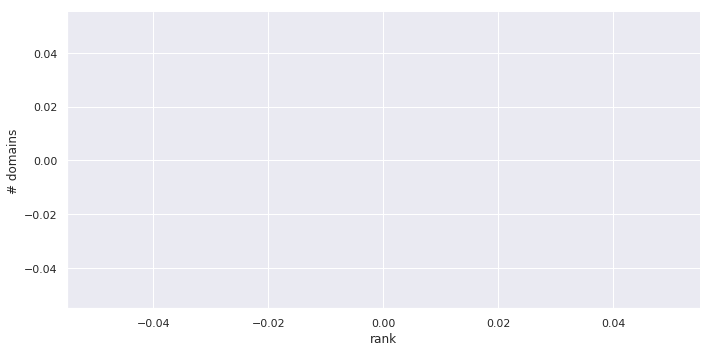

In [12]:
sns.lmplot(x="rank", y="# domains", data=df_n_domains_by_kids_channel, size=5, aspect=2)

AttributeError: 'unicode' object has no attribute 'conjugate'

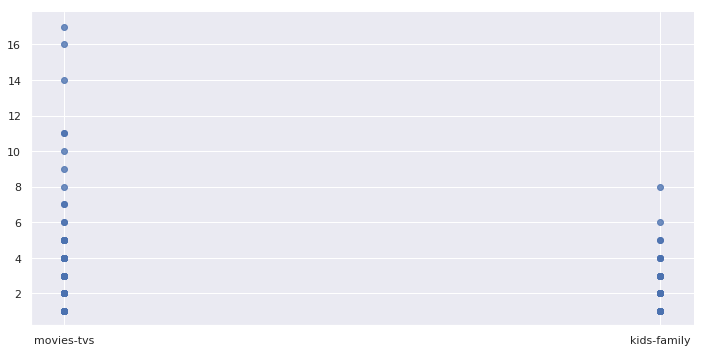

In [13]:
ax = sns.lmplot(x="rank", y="# domains", data=df_n_domains_by_channel, size=5, aspect=2)
ax.set(ylim=(-1, 20))

### TODOs
- what are the domains that are TV/OTT only (e.g. checking on the HTTPArchive data`spotxchange.com` domain is never seen on the web)
- we don't include channels with zero HTTP requests into this analysis (i.e. the above plots need to be redrawn)

In [14]:
df.sort_values("rank", inplace=True)
df[df.url.str.contains("doubleclick")]

,channel_id,start_ts,command,select_idx,eth_src,ip_dst,req_method,url,channel_name,domain,host,rank,category
